In [70]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw

In [50]:
renders_dir = 'renders_output/'

# Check over 92 and 93 those are images where I know there are points we see on both images
image_1_features_path = renders_dir + 'out_0_features.pt'
image_1_path = renders_dir + 'in_0_image.pt'
depth_1_path = renders_dir + 'in_0_gt_depth.pt'

image_2_features_path = renders_dir + 'out_1_features.pt'
image_2_path = renders_dir + 'in_1_image.pt'
depth_2_path = renders_dir + 'in_1_gt_depth.pt'

# In format of tev's (h, w) (in tev it is written (w,h) you can know by moving the cursor from left to right over an image)
points_to_check = [(30, 900)]#, (35, 129), (54, 160), (162, 47)]
colors = [np.array([0,0,255]), np.array([255,0,0]), np.array([0,255,0]), np.array([255,255,0])]

img_1_tensor = torch.load(image_1_path)
img_2_tensor = torch.load(image_2_path)
features_1 = torch.load(image_1_features_path).numpy()
features_2 = torch.load(image_2_features_path).numpy()
depth_1 = torch.load(depth_1_path).numpy()
depth_2 = torch.load(depth_2_path).numpy()

Find matching points from supervision:

In [53]:
depth_idx_1 = depth_1[~np.isnan(depth_1[:,:,0]),2]
depth_idx_2 = depth_2[~np.isnan(depth_2[:,:,0]),2]

idxs_in_both = depth_idx_1[np.isin(depth_idx_1, depth_idx_2)]
idxs_in_both.shape

(690,)

In [181]:
# Samples points to check in image 1:
points_N = 5
np.random.seed(1)

points_to_check_idx = idxs_in_both[np.random.choice(idxs_in_both.shape[0], points_N, replace=False)]

points_to_check = np.argwhere(np.isin(depth_1[:,:,2], points_to_check_idx))
print('Points to check in image 1:', points_to_check)

# Provide the gt:
matching_points = []
for p in points_to_check:
    p_colmap_idx = depth_1[p[0],p[1],2]
    matching_points.append(np.argwhere(depth_2[:,:,2] == p_colmap_idx)[0])
matching_points = np.array(matching_points)
print('Mathcing points in image 2:', matching_points)

print(depth_1[points_to_check[:,0], points_to_check[:,1], 2])
print(depth_2[matching_points[:,0], matching_points[:,1], 2])

Points to check in image 1: [[ 89 669]
 [163 206]
 [574 199]
 [711 822]
 [728 565]]
Mathcing points in image 2: [[ 98 696]
 [183 226]
 [577 230]
 [733 852]
 [740 586]]
[11003. 12246. 12254. 13523.   611.]
[11003. 12246. 12254. 13523.   611.]


In [182]:
def cos_sim(a, b, axis=2):
    return (a * b).sum(axis=axis) / (np.linalg.norm(a, axis=axis) * np.linalg.norm(b, axis=axis))

# a_check = np.array([
#   [1,2,1],
#     # [1,2,1],
#     # [2,4,2],
#     # [1,0,0],
#     # [0,0,1],
#     # [1,0,0]
# ])
# b_check = np.array([
#   [1,2,1],
#     [2,4,2],
#     [1,2,1],
#     [0,0,1],
#     [1,0,0],
#     [1,1,0]
# ])

# cos_sim(a_check, b_check, axis=1)

Now search for nearest and render

[ 89 669]
[ 89 669]
[ 86 710] 0.9935745
[ 85 711] 0.9933552
[ 86 711] 0.9932389
[ 86 712] 0.99323577
[ 85 712] 0.9931031
Cosine Similarity to gt match [ 98 696]  : 0.94583124
[163 206]


/tmp/ipykernel_437379/2485693389.py:2: RuntimeWarning: invalid value encountered in divide
  return (a * b).sum(axis=axis) / (np.linalg.norm(a, axis=axis) * np.linalg.norm(b, axis=axis))


[163 206]
[593 468] 0.99542016
[594 468] 0.9951782
[594 470] 0.9951681
[164 250] 0.9951189
[593 470] 0.99508315
Cosine Similarity to gt match [183 226]  : 0.991479
[574 199]
[574 199]
[605 196] 0.997167
[605 195] 0.99707997
[604 196] 0.9968148
[604 195] 0.99645376
[606 195] 0.9964463
Cosine Similarity to gt match [577 230]  : 0.9857424
[711 822]
[711 822]
[726 863] 0.9922692
[726 864] 0.99214655
[725 863] 0.99207044
[727 864] 0.9920534
[727 863] 0.99199504
Cosine Similarity to gt match [733 852]  : 0.9842846
[728 565]
[728 565]
[586 542] 0.9975551
[586 541] 0.9972654
[586 543] 0.997264
[585 542] 0.9971987
[587 543] 0.9971952
Cosine Similarity to gt match [740 586]  : 0.99394


'img1'

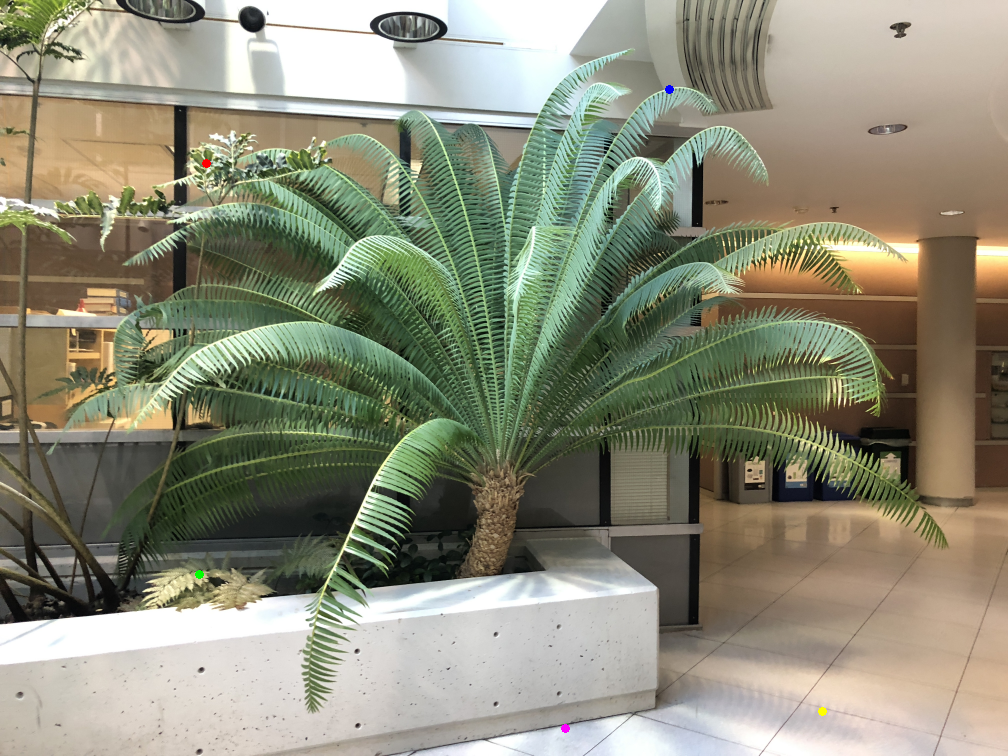

'img2 preds'

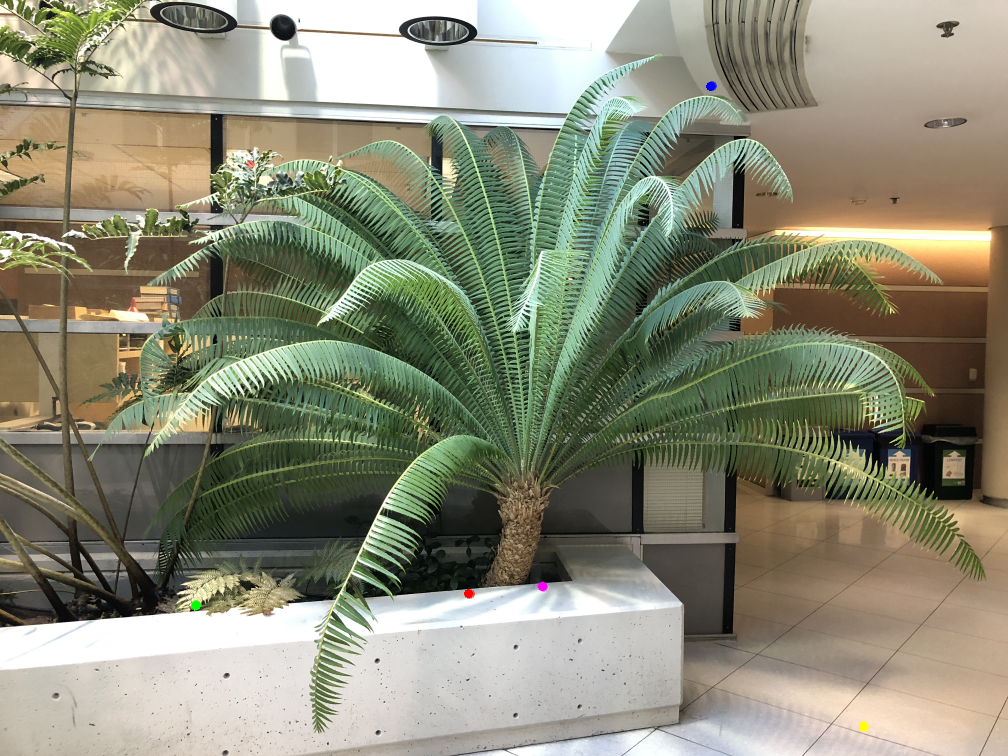

'img2 labels'

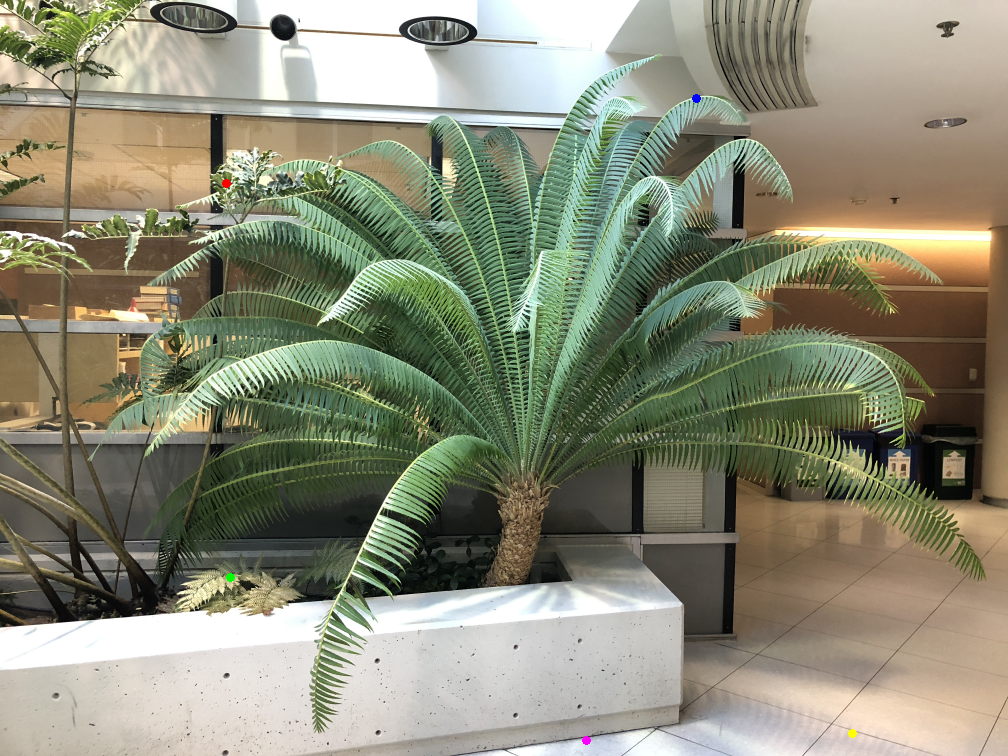

In [183]:
to_pil_image = T.ToPILImage()
colors = [
    np.array([0,0,255]), np.array([255,0,0]), np.array([0,255,0]),
    np.array([255,255,0]), np.array([255,0,255]), np.array([255,255,255])
]

# hwc to chw
img_1 = to_pil_image(img_1_tensor.permute(2, 0, 1))
img_2_for_labels = to_pil_image(img_2_tensor.permute(2, 0, 1))
img_2_for_preds = img_2_for_labels.copy()

orig_draw_r = 4
found_draw_r = 4
k = 5
img_1_drw = ImageDraw.Draw(img_1, 'RGBA')
img_2_gt_drw = ImageDraw.Draw(img_2_for_labels, 'RGBA')
img_2_preds_drw = ImageDraw.Draw(img_2_for_preds, 'RGBA')
for i, point in enumerate(points_to_check):
    gt_match = matching_points[i]
    # Draw on source image to see it
    print(point)
    # Draw ellipse given a bounding box of (x0,y0,x1,y1), x in width, y in height, x1>x0 y1>y0
    img_1_drw.ellipse(xy=(point[1] - orig_draw_r, point[0] - orig_draw_r, \
                          point[1] + orig_draw_r, point[0] + orig_draw_r), fill=tuple(colors[i]))

    # Fine nearest Neighbors
    point_features = features_1[point[0], point[1]]
    # distances = ((features_2 - point_features) ** 2).sum(axis=-1)
    distances = cos_sim(features_2, point_features[np.newaxis, np.newaxis,...])
    nearest_idxs = np.dstack(np.unravel_index(np.argsort(-distances, axis=None), distances.shape))[0, :k, ...]

    print(point)
    for n_p in nearest_idxs:
        print(n_p, distances[n_p[0], n_p[1]])

    nearest_p = nearest_idxs[0]
    # Draw ellipse given a bounding box of (x0,y0,x1,y1), x in width, y in height, x1>x0 y1>y0
    img_2_preds_drw.ellipse(xy=(nearest_p[1] - found_draw_r, nearest_p[0] - found_draw_r, \
                          nearest_p[1] + found_draw_r, nearest_p[0] + found_draw_r), fill=tuple(colors[i]))
    # Now draw next matches with lower 
    for near_p in nearest_idxs[1:]:
        img_2_preds_drw.ellipse(xy=(near_p[1] - found_draw_r, near_p[0] - found_draw_r, \
                              near_p[1] + found_draw_r, near_p[0] + found_draw_r),
                          fill=(colors[i][0], colors[i][1], colors[i][2], 100))
        
    # Draw the gt
    img_2_gt_drw.ellipse(xy=(gt_match[1] - found_draw_r, gt_match[0] - found_draw_r, \
                          gt_match[1] + found_draw_r, gt_match[0] + found_draw_r), fill=tuple(colors[i]))
    print('Cosine Similarity to gt match', gt_match, ' :' , cos_sim(point_features, features_2[gt_match[0], gt_match[1]], axis=0))

display('img1', (img_1))
display('img2 preds', (img_2_for_preds))
display('img2 labels', (img_2_for_labels))

